In [1]:
import brainsss
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy
import random
from scipy.stats import sem
import time
import h5py
import ants
import nibabel as nib
import matplotlib
import pickle
from shutil import copyfile
from mpl_toolkits.axes_grid1 import ImageGrid
from skimage.filters import threshold_otsu as otsu
from scipy.ndimage.morphology import binary_erosion
from scipy.ndimage.morphology import binary_dilation
import matplotlib.patches as mpatches
from matplotlib.colors import LinearSegmentedColormap

/home/users/brezovec/.local/lib/python3.6/site-packages/ants/viz/render_surface_function.py:16: UserWarning: Cant import Plotly. Install it `pip install chart_studio` if you want to use ants.render_surface_function
  "Cant import Plotly. Install it `pip install chart_studio` if you want to use ants.render_surface_function"


In [2]:
def binarize_image(data,scale,binarize):
    if binarize:
        threshold = otsu(data)*scale
        data_binarized = np.where(data>threshold, 1, 0)
        return data_binarized
    else:
        return data
    
def calc_centroid(binary_image):
    return scipy.ndimage.measurements.center_of_mass(binary_image)

def calc_centroid_alex(binary_image):
    return np.argwhere(binary_image==1).mean(0)
        
def plot_centroid(cx,cy,cz,axis,color='r',transpose=False):
    if axis==0:
        plt.scatter(cz,cy,color='k',linewidth=1.5)
        plt.scatter(cz,cy,color=color,linewidth=.5)
    elif axis==1:
        plt.scatter(cz,cx,color='k',linewidth=1.5)
        plt.scatter(cz,cx,color=color,linewidth=.5)
    elif axis==2:
        if transpose:
            plt.scatter(cx,cy,color='k',linewidth=1.5)
            plt.scatter(cx,cy,color=color,linewidth=.5)
        else:
            plt.scatter(cy,cx,color='k',linewidth=1.5)
            plt.scatter(cy,cx,color=color,linewidth=.5)
            
def draw_grid(vlines=5, hlines=5, lw=.5):
    for i in np.arange(0,vlines*20,20):
        plt.axvline(i,color='w',lw=lw)
    for i in np.arange(0,hlines*20,20):
        plt.axhline(i,color='w',lw=lw)
        
def clean_anat(brain):
    brain_copy = brain.copy().astype('float32')
    brain_copy = scipy.ndimage.filters.gaussian_filter(brain_copy, sigma=0.5)

    labels, label_nb = scipy.ndimage.label(brain_copy)
    brain_label = np.bincount(labels.flatten())[1:].argmax()+1

    brain_copy = np.where(labels==brain_label, 1.0, 0.0)

    return brain_copy*brain

In [3]:
bbox = {'x_start': 200, 'x_end': 325,
        'y_start': 150, 'y_end': 225,
        'z_start': 40, 'z_end': 140}

In [4]:
##################
### load masks ###
##################

pvlp_mask = "/oak/stanford/groups/trc/data/Alex/ROI_masks/pvlp_and_plp.nii"
pvlp_mask = ants.image_read(pvlp_mask).numpy()
mask_eroded = binary_erosion(pvlp_mask, structure=np.ones((2,2,2)))
mask_dilated = binary_dilation(mask_eroded, iterations=2)
pvlp_mask_cropped = mask_dilated[bbox['x_start']:bbox['x_end'],
                               bbox['y_start']:bbox['y_end'],
                               bbox['z_start']:bbox['z_end']]

In [6]:
pvlp_mask.shape

(826, 384, 240)

In [5]:
file = "/oak/stanford/groups/trc/data/Yukun/registration/mean_brain/FDA_downsampled_flip.nii"
FDA = ants.image_read(file)

In [22]:
########################
### ANDREWS PIPELINE ###
########################

### DEFINE DIRECTORIES ###
oak = "/oak/stanford/groups/trc/data/"
warp_types = ['direct_affine', 'direct_syn', 'localmean_ANTS', 'localmean_synthmorph']

directories_clandinin = {
     'direct_affine': "Brezovec/2P_Imaging/20221029_FDA_direct_affine/clandinin",
     'direct_syn': "Brezovec/2P_Imaging/20221029_FDA_direct_syn/clandinin",
     'localmean_ANTS': "Alex/clab_data/LC11/func/aligned_to_FDA/",
     'localmean_synthmorph': "Alex/clab_data/LC11/func/synthmorph_to_FDA"
}

for warp_type in warp_types:
    directories_clandinin[warp_type] = os.path.join(oak, directories_clandinin[warp_type])
    
directories_murthy = {
     'direct_affine': "Brezovec/2P_Imaging/20221029_FDA_direct_affine/murthy",
     'direct_syn': "Brezovec/2P_Imaging/20221029_FDA_direct_syn/murthy",
     'localmean_ANTS': "Alex/albert_data/LC11/func/aligned_to_FDA/",
     'localmean_synthmorph': "Alex/albert_data/LC11/func/synthmorph_to_FDA"
}
    
for warp_type in warp_types:
    directories_murthy[warp_type] = os.path.join(oak, directories_murthy[warp_type])
    

In [29]:
os.listdir("/oak/stanford/groups/trc/data/Alex/albert_data/LC11/func/")

['aligned_to_FDA',
 'raw',
 'registered',
 'average_green_LC11_albert_synthmorph.nii',
 'average_green_LC11_albert.nii',
 'synthmorph_to_FDA',
 'synthmorph_to_FDA_luke_pipeline',
 'average_green_LC11_mlab.nii',
 'average_green_LC11_albert_fda.nii']

In [6]:
######################
### LUKES PIPELINE ###
######################

### DEFINE DIRECTORIES ###
oak = "/oak/stanford/groups/trc/data/"
warp_types = ['direct_affine', 'direct_syn', 'localmean_ANTS', 'localmean_synthmorph']

directories_clandinin = {
     'direct_affine': "Brezovec/2P_Imaging/20221029_FDA_direct_affine/clandinin",
     'direct_syn': "Brezovec/2P_Imaging/20221029_FDA_direct_syn/clandinin",
     'localmean_ANTS': "Brezovec/2P_Imaging/20230130_LC11_full_analysis/local_to_FDA/clandinin",###<-------
     'localmean_synthmorph': "Alex/clab_data/LC11/func/synthmorph_to_FDA_luke_pipeline" ###<-------
}

for warp_type in warp_types:
    directories_clandinin[warp_type] = os.path.join(oak, directories_clandinin[warp_type])
    
directories_murthy = {
     'direct_affine': "Brezovec/2P_Imaging/20221029_FDA_direct_affine/murthy",
     'direct_syn': "Brezovec/2P_Imaging/20221029_FDA_direct_syn/murthy",
     'localmean_ANTS': "Brezovec/2P_Imaging/20230130_LC11_full_analysis/local_to_FDA/murthy",###<-------
     'localmean_synthmorph': "Alex/albert_data/LC11/func/synthmorph_to_FDA_luke_pipeline" ###<-------
}
    
for warp_type in warp_types:
    directories_murthy[warp_type] = os.path.join(oak, directories_murthy[warp_type])
    

In [22]:
###########################################
### Load warped indiv LC11 gloms in FDA ###
###########################################

######################################
### HERE IS KEY VARIABLE TO CHANGE ###
warp_type = 'localmean_ANTS'
######################################

brains = {}
brains_cropped = {}
brain_types = ['clandinin', 'murthy', 'clandinin_flip', 'murthy_flip', 'connectome']
for brain_type in brain_types:
    if 'clandinin' in brain_type:
        dir_ = directories_clandinin[warp_type]
    elif 'murthy' in brain_type:
        dir_ = directories_murthy[warp_type]
    elif 'connectome' in brain_type:
        LC11_fda_path = "/oak/stanford/groups/trc/data/Alex/clab_data/LC11/LC11_FDA_ds_flip.nii"
        LC11_fda = ants.image_read(LC11_fda_path)[:]
        LC11_fda_cropped = LC11_fda[bbox['x_start']:bbox['x_end'],
                           bbox['y_start']:bbox['y_end'],
                           bbox['z_start']:bbox['z_end']]
        brains[brain_type] = [LC11_fda]
        brains_cropped[brain_type] = [LC11_fda_cropped]
        continue
        
    brains[brain_type] = []
    files = [x for x in os.listdir(dir_) if 'green' in x] ### just need to switch this for localmean_synthmorph
    #files = [x for x in os.listdir(dir_)]
    for file in files:
        print(file)
        to_load = os.path.join(dir_,file)
        image = ants.image_read(to_load)
        
        if 'flip' in brain_type:
            image = image[::-1,:,:]
        
        brains[brain_type].append(image)

210223_02_green-to-localmeansyn6.nii
210216_04_green-to-localmeansyn6.nii
210218_02_green-to-localmeansyn6.nii
210223_04_green-to-localmeansyn6.nii
210223_01_green-to-localmeansyn6.nii
210208_02_green-to-localmeansyn6.nii
210223_03_green-to-localmeansyn6.nii
210208_03_green-to-localmeansyn6.nii
210216_02_green-to-localmeansyn6.nii
220426_LC11_vol2_local_atlas_green-to-localmeansyn6.nii
220419_LC11_vol2_local_atlas_green-to-localmeansyn6.nii
220426_LC11_vol1_local_atlas_green-to-localmeansyn6.nii
220425_LC11_vol1_local_atlas_green-to-localmeansyn6.nii
220413_LC11_vol1_local_atlas_green-to-localmeansyn6.nii
220420_LC11_vol2_local_atlas_green-to-localmeansyn6.nii
220412_LC11_vol1_local_atlas_green-to-localmeansyn6.nii
220420_LC11_vol1_local_atlas_green-to-localmeansyn6.nii
210223_02_green-to-localmeansyn6.nii
210216_04_green-to-localmeansyn6.nii
210218_02_green-to-localmeansyn6.nii
210223_04_green-to-localmeansyn6.nii
210223_01_green-to-localmeansyn6.nii
210208_02_green-to-localmeansyn6.n

In [27]:
brains['clandinin'][0].shape

(826, 384, 240)

In [8]:
for brain_type in brain_types:
    brains_cropped[brain_type] = []
    for i in range(len(brains[brain_type])):
        ### crop to bounding box
        brains_cropped[brain_type].append(brains[brain_type][i][bbox['x_start']:bbox['x_end'],
                   bbox['y_start']:bbox['y_end'],
                   bbox['z_start']:bbox['z_end']])

In [23]:
########################################################
### Generate normalized mean images of green channel -      NOT CROPPED
########################################################

meanbrains = {}
for brain_type in brain_types:
    meanbrain = np.zeros(brains[brain_type][0].shape)
    for i in range(len(brains[brain_type])): 
        try:
            meanbrain += brains[brain_type][i]
        except:
            meanbrain += brains[brain_type][i].numpy()
    meanbrains[brain_type] = meanbrain

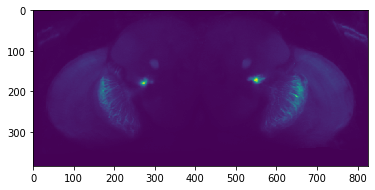

In [24]:
plt.imshow(meanbrains['clandinin'][:,:,80].T)

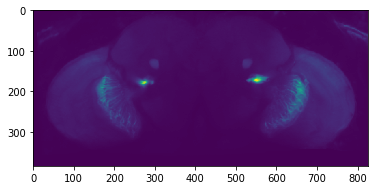

In [18]:
plt.imshow(meanbrains['clandinin'][:,:,80].T)

In [25]:
save_file = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20220704_LC11/20230220_temp.nii"
nib.Nifti1Image(meanbrains['clandinin'], np.eye(4)).to_filename(save_file)

In [27]:
########################################################
### Generate normalized mean images of green channel -      CROPPED
########################################################

meanbrains_cropped = {}
for brain_type in brain_types:
    meanbrain = np.zeros(brains_cropped[brain_type][0].shape)
    for i in range(len(brains_cropped[brain_type])):
        max_value = np.max(brains_cropped[brain_type][i])
        if max_value == 0:
            max_value = 1            
        meanbrain += brains_cropped[brain_type][i]/max_value
    meanbrains_cropped[brain_type] = meanbrain

In [18]:
###########################
### calculate centroids ###
###########################

thresh_scales = {'clandinin': [1,1,1,1,1,1,1,1,1],
                 'murthy': [2,2,2,1.5,1.5,1.5,1.5,1.5],
                 'clandinin_flip': [1,1,1,1,1,1,2,1,1],
                 'murthy_flip': [1.5,2,2,2,1.5,1,1,2],
                 'connectome':[1]}

centroids = {}
for brain_type in brain_types:
    centroids[brain_type] = []
    for i in range(len(brains_cropped[brain_type])):
        try:
            binary_image = binarize_image(brains_cropped[brain_type][i],thresh_scales[brain_type][i],binarize=True)
        except:
            continue

        binary_image*=pvlp_mask_cropped
        binary_image = clean_anat(binary_image)
        cx,cy,cz = calc_centroid(binary_image)
        centroids[brain_type].append((cx,cy,cz))

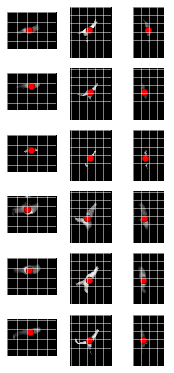

In [20]:
########################################
### visually confirm good thresholds ###
########################################

plt.figure(figsize=(3,10))
binarize=True
brain_type = 'murthy'
for i in range(len(brains_cropped[brain_type])):
    for axis in [0,1,2]:
        plt.subplot(9,3,(3*i+axis)+1)
        binary_image = binarize_image(brains_cropped[brain_type][i],thresh_scales[brain_type][i],binarize)
        binary_image*=pvlp_mask_cropped
        binary_image = clean_anat(binary_image)
        plt.imshow(np.mean(binary_image,axis=axis),cmap='Greys_r')
        draw_grid()
        plt.axis('off')
        cx,cy,cz = calc_centroid(binary_image)
        plot_centroid(cx,cy,cz,axis)

In [66]:
# this LC11 cell is too dim/too low SNR
del centroids['murthy_flip'][-3]

In [21]:
### SAVE CENTROIDS
save_file = f"/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20221217_LC11_centroids/20221217_{warp_type}_lukepipeline"
np.save(save_file, centroids, allow_pickle=True)

In [ ]:
### this these again and visualize all (some sythmorph need better thresholds)

# Load all centroids and plot graphs (start here)

In [18]:
### ANDREW PIPELINE ###

warp_types = ['direct_affine', 'direct_syn', 'localmean_ANTS', 'localmean_synthmorph']

centroids = {}
for warp_type in warp_types:
    file = f"/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20221217_LC11_centroids/20221217_{warp_type}.npy"
    centroids[warp_type] = np.load(file, allow_pickle=True).item()

In [29]:
### LUKE PIPELINE ###
warp_types = ['direct_affine', 'direct_syn', 'localmean_ANTS', 'localmean_synthmorph']

centroids = {}
for warp_type in warp_types:
    if warp_type in ['direct_affine', 'direct_syn']:
        file = f"/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20221217_LC11_centroids/20221217_{warp_type}.npy"
    else:
        file = f"/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20221217_LC11_centroids/20221217_{warp_type}_lukepipeline.npy"
    centroids[warp_type] = np.load(file, allow_pickle=True).item()

In [30]:
comparison_means_all = {}
comparison_std_all = {}

for warp_type in warp_types:

    comparisons = [('clandinin', 'clandinin'), #intra
                   ('murthy', 'murthy'),#intra
                   ('clandinin_flip', 'clandinin_flip'),#intra
                   ('murthy_flip', 'murthy_flip'),#intra
                   ('clandinin', 'clandinin_flip'),#cross-hemi
                   ('murthy', 'murthy_flip'),#cross-hemi
                   ('clandinin', 'murthy'),#cross-lab
                   ('clandinin', 'murthy_flip'),#cross-lab
                   ('clandinin_flip', 'murthy'),#cross-lab
                   ('clandinin_flip', 'murthy_flip'),#cross-lab
                   ('clandinin', 'connectome'),#connectome
                   ('clandinin_flip', 'connectome'),#connectome
                   ('murthy', 'connectome'),#connectome
                   ('murthy_flip', 'connectome')]#connectome

    comparison_means = {}
    comparison_std = {}
    for comparison in comparisons:
        brain_type_1 = comparison[0]
        brain_type_2 = comparison[1]

        pairwise_diffs = []
        for axis in [0,1,2]:
            a=[i[axis] for i in centroids[warp_type][brain_type_1]]
            b=[i[axis] for i in centroids[warp_type][brain_type_2]]

            ### if it is an intra comparison, skip comparisons of exact same brains
            if brain_type_1 == brain_type_2:
                pairwise_diff = [np.abs((x-y)*.76) for i,x in enumerate(a) for j,y in enumerate(a) if i != j]
            else:
                pairwise_diff = [np.abs((x-y)*.76) for x in a for y in b]
            pairwise_diffs.append(pairwise_diff)

        ### calculate distances given all 3 axes
        distances = (np.asarray(pairwise_diffs[0])**2 +
                 np.asarray(pairwise_diffs[1])**2 + 
                 np.asarray(pairwise_diffs[2])**2)**0.5

        comparison_means[comparison] = np.mean(distances)
        comparison_std[comparison] = np.std(distances)
    comparison_means_all[warp_type] = comparison_means
    comparison_std_all[warp_type] = comparison_std

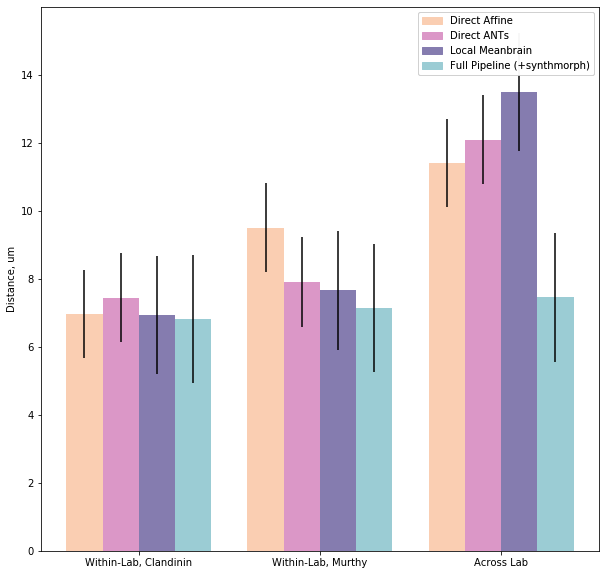

In [31]:
plt.figure(figsize=(10,10))
bar_width = 0.2
xs_ = [0,.2,.4,.6]
colors = ['#FACEB2', "#DB97C7", "#857CAF", "#9BCCD4"]
labels = ['Direct Affine', 'Direct ANTs','Local Meanbrain', 'Full Pipeline (+synthmorph)']

comp_to_plot = [('clandinin', 'clandinin'),
                ('murthy', 'murthy'),
                ('clandinin', 'murthy')]
for j,comparsion in enumerate(comp_to_plot):
    xs = [i+j for i in xs_]
    group_values = []
    group_std = []
    for warp_type in warp_types:
        group_values.append(comparison_means_all[warp_type][comparsion])
        group_std.append(comparison_std_all[warp_type][comparison]/3)
    plt.bar(xs,group_values,
            yerr=group_std,
            width=bar_width,
            color=colors)

plt.ylabel('Distance, um')
plt.xticks([.3,1.3,2.3], ['Within-Lab, Clandinin', 'Within-Lab, Murthy', 'Across Lab'])

ax = plt.gca()
all_handles = []
for i in range(len(colors)):
    all_handles.append(mpatches.Patch(color=colors[i], label=labels[i]))
leg = ax.legend(handles=all_handles)
ax.add_artist(leg)

# work on visualization

In [32]:
meanbrains_cropped['clandinin'].shape

(125, 75, 100)

In [33]:
# tight crop for visualizing in figures
x_start = 30
x_stop = 110
y_start = 5
y_stop = 50
z_start = 0
z_stop = 80

In [34]:
def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 79.5, 44.5, -0.5)

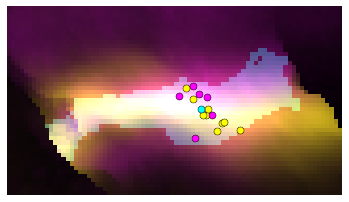

In [35]:
axis=0

image1 = meanbrains_cropped['clandinin']*pvlp_mask_cropped
image2 = meanbrains_cropped['murthy']*pvlp_mask_cropped
image3 = meanbrains_cropped['connectome']*pvlp_mask_cropped

image1 = image1[x_start:x_stop,y_start:y_stop,z_start:z_stop]
image2 = image2[x_start:x_stop,y_start:y_stop,z_start:z_stop]
image3 = image3[x_start:x_stop,y_start:y_stop,z_start:z_stop]

image1 = np.max(image1,axis=axis)
image2 = np.max(image2,axis=axis)
image3 = np.max(image3,axis=axis)

image1 = NormalizeData(image1)
image2 = NormalizeData(image2)
image3 = NormalizeData(image3)

cmap = LinearSegmentedColormap.from_list('mycmap', ['black', 'yellow'])
rgba1 = cmap(image1)
cmap = LinearSegmentedColormap.from_list('mycmap', ['black', 'magenta'])
rgba2 = cmap(image2)
cmap = LinearSegmentedColormap.from_list('mycmap', ['black', 'cyan'])
rgba3 = cmap(image3)

merge = rgba1+rgba2+rgba3/3
merge = NormalizeData(merge)
plt.imshow(merge*2)

for i in range(len(centroids[warp_type]['clandinin'])):
    cx,cy,cz = centroids[warp_type]['clandinin'][i]
    plot_centroid(cx-x_start,cy-y_start,cz-z_start,axis,color='yellow')
for i in range(len(centroids[warp_type]['murthy'])):
    cx,cy,cz = centroids[warp_type]['murthy'][i]
    plot_centroid(cx-x_start,cy-y_start,cz-z_start,axis,color='magenta')
for i in range(len(centroids[warp_type]['connectome'])):
    cx,cy,cz = centroids[warp_type]['connectome'][i]
    plot_centroid(cx-x_start,cy-y_start,cz-z_start,axis,color='cyan')
    
plt.axis('off')

In [36]:
def make_overlay(axis):
    image1 = meanbrains_cropped['clandinin']*pvlp_mask_cropped
    image2 = meanbrains_cropped['murthy']*pvlp_mask_cropped
    image3 = meanbrains_cropped['connectome']*pvlp_mask_cropped

    image1 = image1[x_start:x_stop,y_start:y_stop,z_start:z_stop]
    image2 = image2[x_start:x_stop,y_start:y_stop,z_start:z_stop]
    image3 = image3[x_start:x_stop,y_start:y_stop,z_start:z_stop]

    image1 = np.max(image1,axis=axis)
    image2 = np.max(image2,axis=axis)
    image3 = np.max(image3,axis=axis)

    image1 = NormalizeData(image1)
    image2 = NormalizeData(image2)
    image3 = NormalizeData(image3)

    cmap = LinearSegmentedColormap.from_list('mycmap', ['black', 'yellow'])
    rgba1 = cmap(image1)
    cmap = LinearSegmentedColormap.from_list('mycmap', ['black', 'magenta'])
    rgba2 = cmap(image2)
    cmap = LinearSegmentedColormap.from_list('mycmap', ['black', 'cyan'])
    rgba3 = cmap(image3)

    merge = rgba1+rgba2+rgba3/3
    merge = NormalizeData(merge)*2
    return merge

def plot_centroid(cx,cy,cz,axis,color='r',transpose=False):
    if axis==0:
        plt.scatter(cz,cy,color='k',s=1000)
        plt.scatter(cz,cy,color=color,s=500)
    elif axis==1:
        plt.scatter(cz,cx,color='k',s=1000)
        plt.scatter(cz,cx,color=color,s=500)
    elif axis==2:
        if transpose:
            plt.scatter(cx,cy,color='k',s=1000)
            plt.scatter(cx,cy,color=color,s=500)
        else:
            plt.scatter(cy,cx,color='k',s=1000)
            plt.scatter(cy,cx,color=color,s=500)

def plot_all_centroids(axis,transpose):
    for i in range(len(centroids[warp_type]['clandinin'])):
        cx,cy,cz = centroids[warp_type]['clandinin'][i]
        plot_centroid(cx-x_start,cy-y_start,cz-z_start,axis,color='yellow',transpose=transpose)
    for i in range(len(centroids[warp_type]['murthy'])):
        cx,cy,cz = centroids[warp_type]['murthy'][i]
        plot_centroid(cx-x_start,cy-y_start,cz-z_start,axis,color='magenta',transpose=transpose)
    for i in range(len(centroids[warp_type]['connectome'])):
        cx,cy,cz = centroids[warp_type]['connectome'][i]
        plot_centroid(cx-x_start,cy-y_start,cz-z_start,axis,color='cyan',transpose=transpose)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


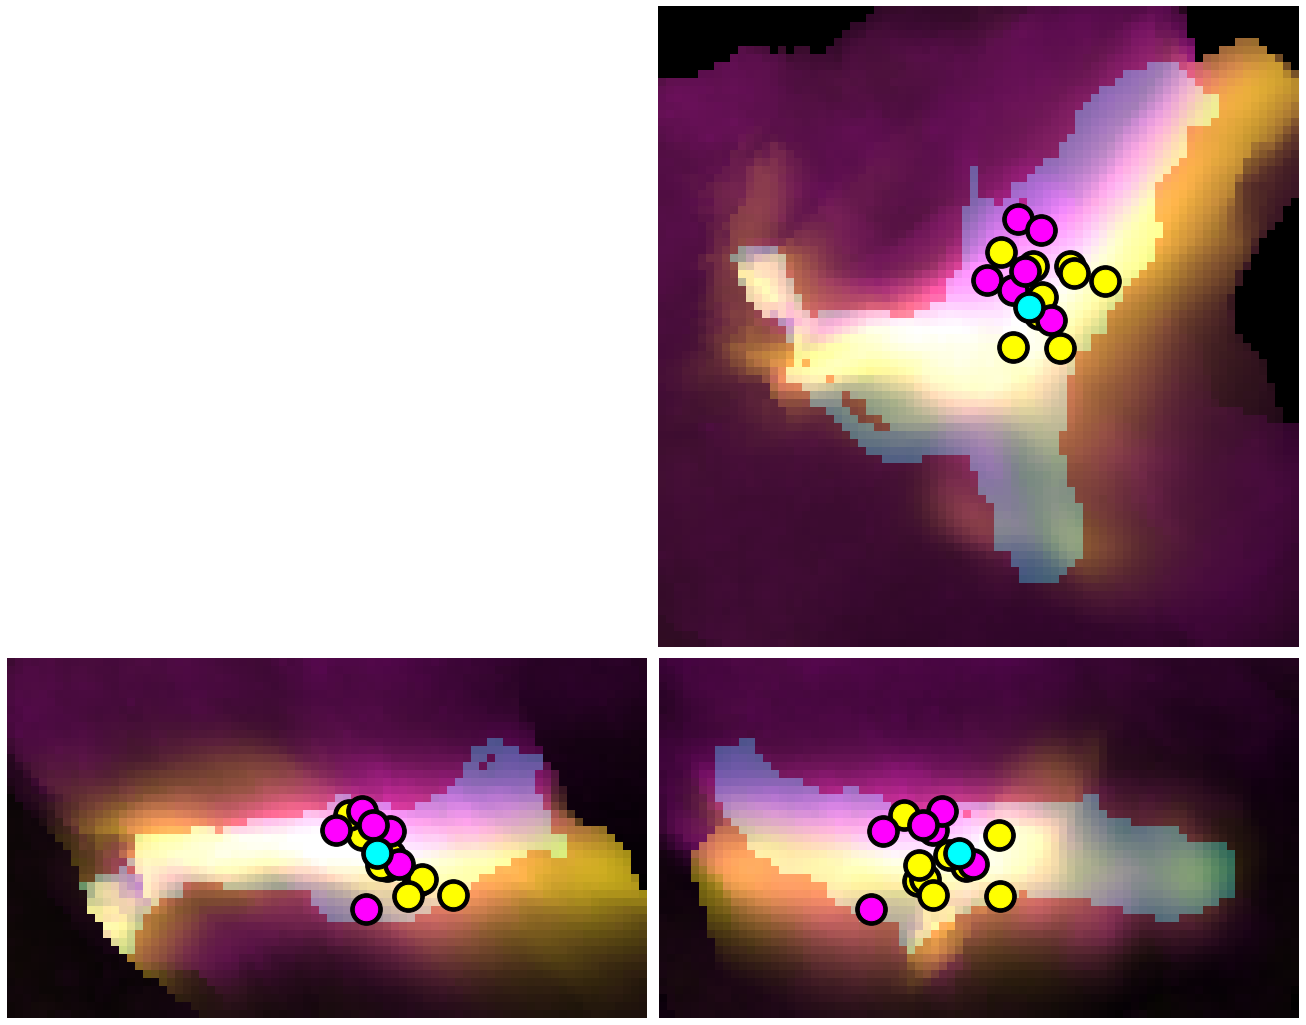

In [37]:
fig = plt.figure(figsize=(10,10))

### BOTTOM LEFT ###
fig.add_axes([-.905,-.4,1,.5])
axis = 0
merge = make_overlay(axis)
plt.imshow(merge)
plot_all_centroids(axis,transpose=False)
plt.axis('off')

### BOTTOM RIGHT ###
fig.add_axes([0,-.4,1,.5])
axis = 2
merge = make_overlay(axis)
plt.imshow(np.swapaxes(merge,0,1))
plot_all_centroids(axis,transpose=True)
plt.axis('off')

### TOP RIGHT ###
fig.add_axes([.055,.06,.89,1])
axis = 1
merge = make_overlay(axis)
plt.imshow(merge)
plot_all_centroids(axis,transpose=False)
plt.axis('off')

save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, f'{timestr}')
plt.savefig(fname,dpi=300,bbox_inches='tight',transparent=True)

(-0.5, 239.5, 383.5, -0.5)

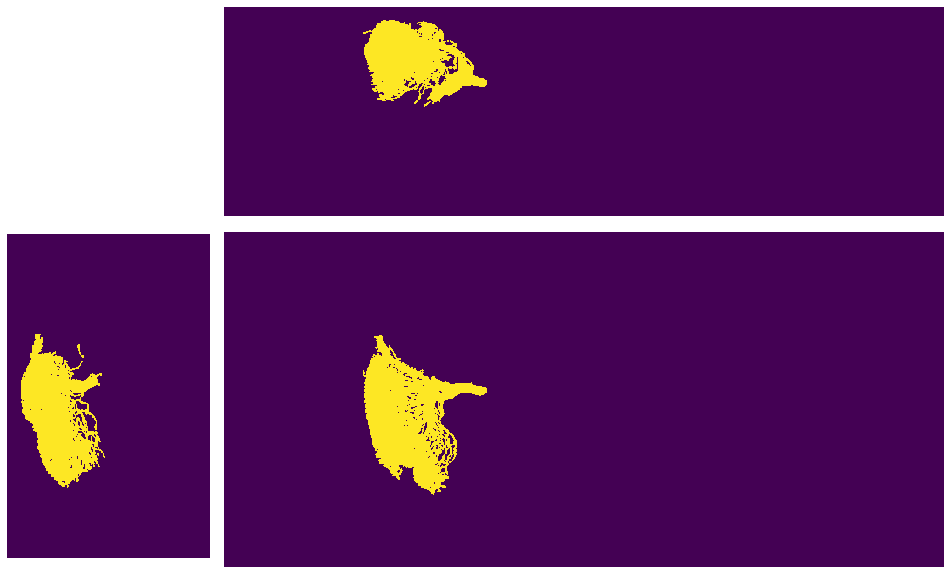

In [218]:
fig = plt.figure(figsize=(10,10))

fig.add_axes([0,0,1,1])
plt.imshow(np.max(meanbrains['connectome'],axis=1).T)
plt.axis('off')

fig.add_axes([0,-.4,1,1])
plt.imshow(np.max(meanbrains['connectome'],axis=2).T)
plt.axis('off')

fig.add_axes([-.66,-.12,1,.45])
plt.imshow(np.max(meanbrains['connectome'],axis=0))
plt.axis('off')

# Visualize red channel in various barin regions

In [ ]:
########################
### ANDREWS PIPELINE ###
########################

### DEFINE DIRECTORIES ###
oak = "/oak/stanford/groups/trc/data/"
warp_types = ['direct_affine', 'direct_syn', 'localmean_ANTS', 'localmean_synthmorph']

directories_clandinin = {
     'direct_affine': "Brezovec/2P_Imaging/20221029_FDA_direct_affine/clandinin",
     'direct_syn': "Brezovec/2P_Imaging/20221029_FDA_direct_syn/clandinin",
     'localmean_ANTS': "Alex/clab_data/LC11/anat/registered/",
     'localmean_synthmorph': "Alex/clab_data/LC11/func/synthmorph_to_FDA"
}

for warp_type in warp_types:
    directories_clandinin[warp_type] = os.path.join(oak, directories_clandinin[warp_type])
    
directories_murthy = {
     'direct_affine': "Brezovec/2P_Imaging/20221029_FDA_direct_affine/murthy",
     'direct_syn': "Brezovec/2P_Imaging/20221029_FDA_direct_syn/murthy",
     'localmean_ANTS': "Alex/albert_data/LC11/func/aligned_to_FDA/",
     'localmean_synthmorph': "Alex/albert_data/LC11/func/synthmorph_to_FDA"
}
    
for warp_type in warp_types:
    directories_murthy[warp_type] = os.path.join(oak, directories_murthy[warp_type])

In [47]:
os.listdir("/oak/stanford/groups/trc/data/Alex/clab_data/LC11/anat/")

['raw',
 'mbrain',
 'templates',
 'average_red_LC11_clab_meanbrain_space.nii',
 'registered']

In [48]:
########################
### ANDREWS PIPELINE ###
########################

### DEFINE DIRECTORIES ###
oak = "/oak/stanford/groups/trc/data/"
warp_types = ['direct_affine', 'direct_syn', 'localmean_ANTS', 'localmean_synthmorph']

directories_clandinin = {
     'direct_affine': "Brezovec/2P_Imaging/20221029_FDA_direct_affine/clandinin",
     'direct_syn': "Brezovec/2P_Imaging/20221029_FDA_direct_syn/clandinin",
     'localmean_ANTS': "Alex/clab_data/LC11/func/aligned_to_FDA/",
     'localmean_synthmorph': "Alex/clab_data/LC11/func/synthmorph_to_FDA"
}

for warp_type in warp_types:
    directories_clandinin[warp_type] = os.path.join(oak, directories_clandinin[warp_type])
    
directories_murthy = {
     'direct_affine': "Brezovec/2P_Imaging/20221029_FDA_direct_affine/murthy",
     'direct_syn': "Brezovec/2P_Imaging/20221029_FDA_direct_syn/murthy",
     'localmean_ANTS': "Alex/albert_data/LC11/func/aligned_to_FDA/",
     'localmean_synthmorph': "Alex/albert_data/LC11/func/synthmorph_to_FDA"
}
    
for warp_type in warp_types:
    directories_murthy[warp_type] = os.path.join(oak, directories_murthy[warp_type])

In [58]:
os.listdir("/oak/stanford/groups/trc/data/Alex/clab_data/LC11/anat/registered")

['210216_02_red_registered.nii',
 '210223_01_red_registered.nii',
 '210208_03_red_registered.nii',
 '210223_02_red_registered.nii',
 '210218_02_red_registered.nii',
 '210223_04_red_registered.nii',
 '210208_02_red_registered.nii',
 '210223_03_red_registered.nii',
 '210216_04_red_registered.nii']